## isomiR analysis for miRNA datasets

references:

D. Farrell, R. G. Shaughnessy, L. Britton, D. E. MacHugh, B. Markey, and S. V. Gordon, “The Identification of Circulating MiRNA in Bovine Serum and Their Potential as Novel Biomarkers of Early Mycobacterium avium subsp paratuberculosis Infection,” PLoS One, vol. 10, no. 7, p. e0134310, 2015.

P. Vegh, A. B. K. Foroushani, D. a Magee, M. S. McCabe, J. a Browne, N. C. Nalpas, K. M. Conlon, S. V Gordon, D. G. Bradley, D. E. MacHugh, and D. J. Lynn, “Profiling microRNA expression in bovine alveolar macrophages using RNA-seq.,” Vet. Immunol. Immunopathol., vol. 155, no. 4, pp. 238–44, Oct. 2013.

N. Hooten, M. Fitzpatrick, and W. W. 3rd, “Age-related changes in microRNA levels in serum,” Aging (Albany …, vol. 5, no. 10, pp. 725–740, 2013.

M. K. McGahon, J. M. Yarham, A. Daly, J. Guduric-Fuchs, L. J. Ferguson, D. a. Simpson, and A. Collins, “Distinctive Profile of IsomiR Expression and Novel MicroRNAs in Rat Heart Left Ventricle,” PLoS One, vol. 8, no. 6, 2013.

A. Wojcicka, M. Swierniak, O. Kornasiewicz, W. Gierlikowski, M. Maciag, M. Kolanowska, M. Kotlarek, B. Gornicka, L. Koperski, G. Niewinski, M. Krawczyk, and K. Jazdzewski, “Next generation sequencing reveals microRNA isoforms in liver cirrhosis and hepatocellular carcinoma.,” Int. J. Biochem. Cell Biol., vol. 53, pp. 208–17, 2014.

In [1]:
#general isomir analysis
import glob,os
import pandas as pd
import numpy as np
import mirnaseq.mirdeep2 as mdp
import mirnaseq.srnabench as srb
from mirnaseq import base, analysis, ensembl
pd.set_option('display.width', 300)
%matplotlib inline
import matplotlib as mpl
import pylab as plt
import seaborn as sns
base.seabornsetup()
from scipy.stats import norm,rayleigh
sns.set_style("ticks", {'axes.facecolor': '#F7F7F7','legend.frameon': True})
sns.set_context("notebook", font_scale=1.5)
plt.rcParams['savefig.dpi']=150
plt.rcParams['legend.fontsize']=25

In [2]:
dwiso = pd.read_csv('douwe_isomirs_all.csv')
iciso = pd.read_csv('iconmap_isomirs_all.csv')
nkiso = pd.read_csv('nick_isomirs_all.csv')
viso = pd.read_csv('vegh_isomirs_all.csv')
htiso = pd.read_csv('hooten_isomirs_all.csv')
mciso = pd.read_csv('mcgahon_isomirs_all.csv')
wjiso = pd.read_csv('wojcicka_isomirs_all.csv')
raiso = pd.read_csv('rau_isomirs_all.csv')

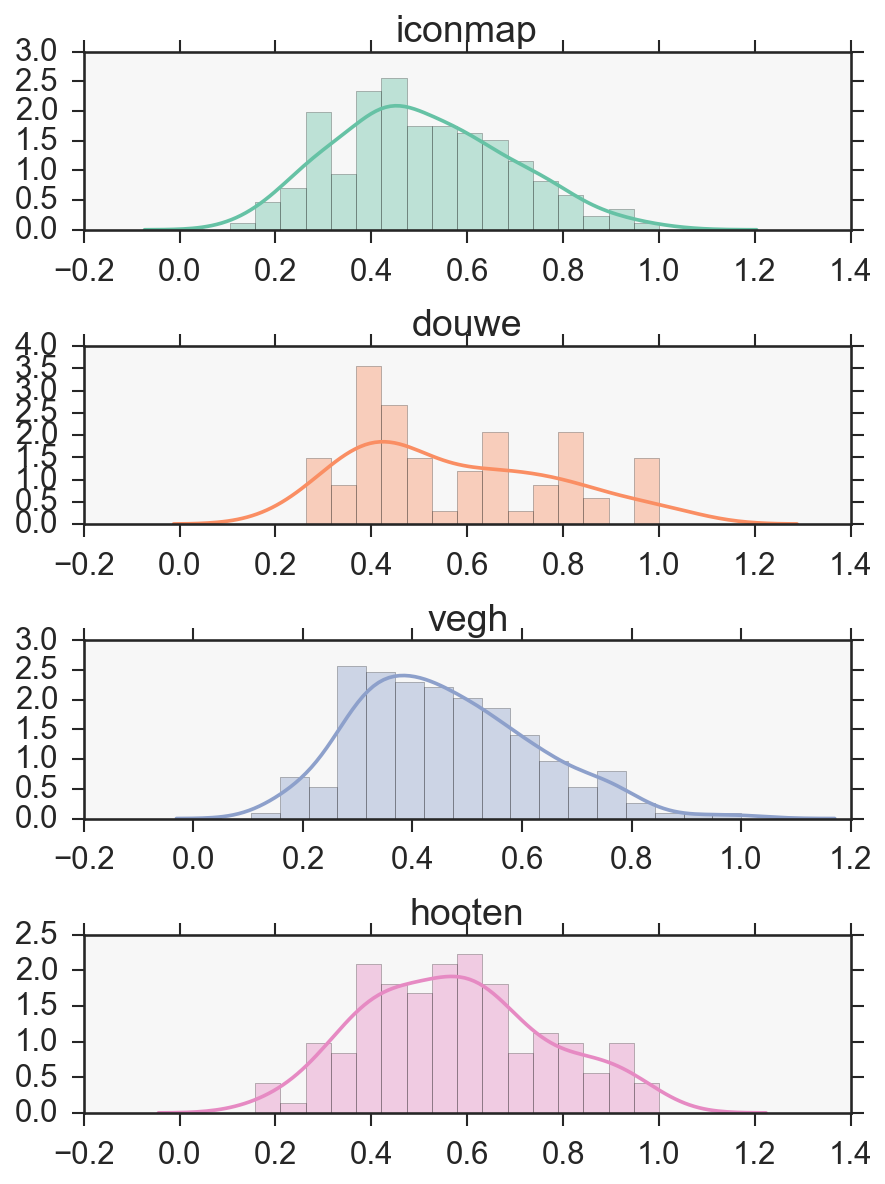

In [3]:
#isomir distr comparisons
dw = pd.read_csv('douwe_isomirs_dominant.csv')
ic = pd.read_csv('iconmap_isomirs_dominant.csv')
v = pd.read_csv('vegh_isomirs_dominant.csv')
ht = pd.read_csv('hooten_isomirs_dominant.csv')
mc = pd.read_csv('mcgahon_isomirs_dominant.csv')
wj = pd.read_csv('wojcicka_isomirs_dominant.csv')
ra =  pd.read_csv('rau_isomirs_dominant.csv')
nk = pd.read_csv('nick_isomirs_dominant.csv')
datasets = {'douwe':dw,'iconmap':ic,'vegh':v,'hooten':ht}#'nick':nk,'mcgahon':mc}#,'wojcicka':wj,'rau':ra}
l=len(datasets)

#filter out low abundance isomirs
for d in datasets:
    f=datasets[d]
    datasets[d] = f[f.total>200]
fig,ax=plt.subplots(l,1,figsize=(6,8))
grid=ax.flat
bins = np.linspace(0, 1, 20)
clrs = sns.color_palette("Set2", l)
i=0
for d in datasets:
    g=sns.distplot(datasets[d].domisoperc,bins=bins,ax=grid[i],color=clrs[i],kde=True)#kde_kws={"lw": 2})
    g.set_title(d)
    g.set_xlabel('')
    i+=1
plt.tight_layout()
'''fig,ax=plt.subplots(1,1,figsize=(10,8))
i=0
for d in datasets:
    f=datasets[d]   
    g=sns.kdeplot(f.domisoperc,ax=ax,color=clrs[i],lw=3,label=d)
    i+=1
fig.suptitle('dominant isomir percentages',fontsize=20)'''
fig.savefig('isomir_domperc_dists.png')

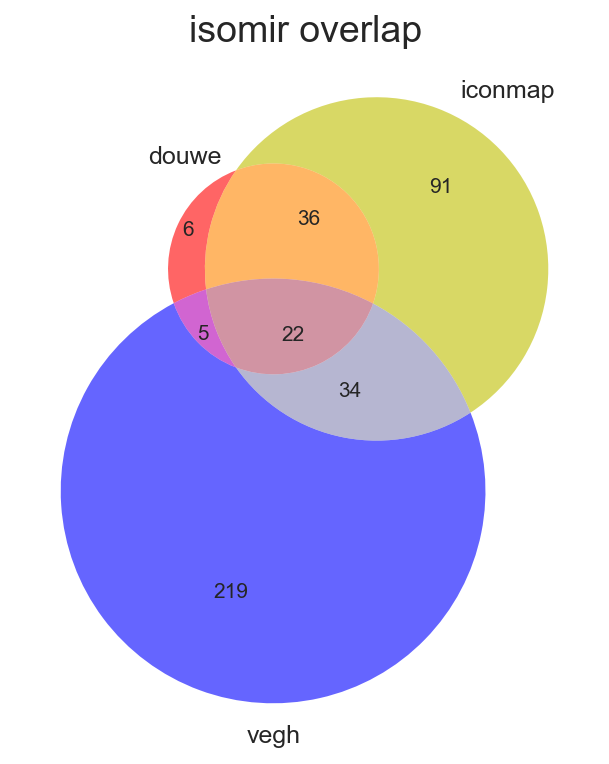

In [4]:
ic.read
fig,ax=plt.subplots(1,1,figsize=(6,6))
vd=base.venndiagram([dw.read,ic.read,v.read],['douwe','iconmap','vegh'],set_colors=['r','y','b'], alpha=0.6,ax=ax)
ax.set_title('isomir overlap')
plt.savefig('isomir_overlap.png')

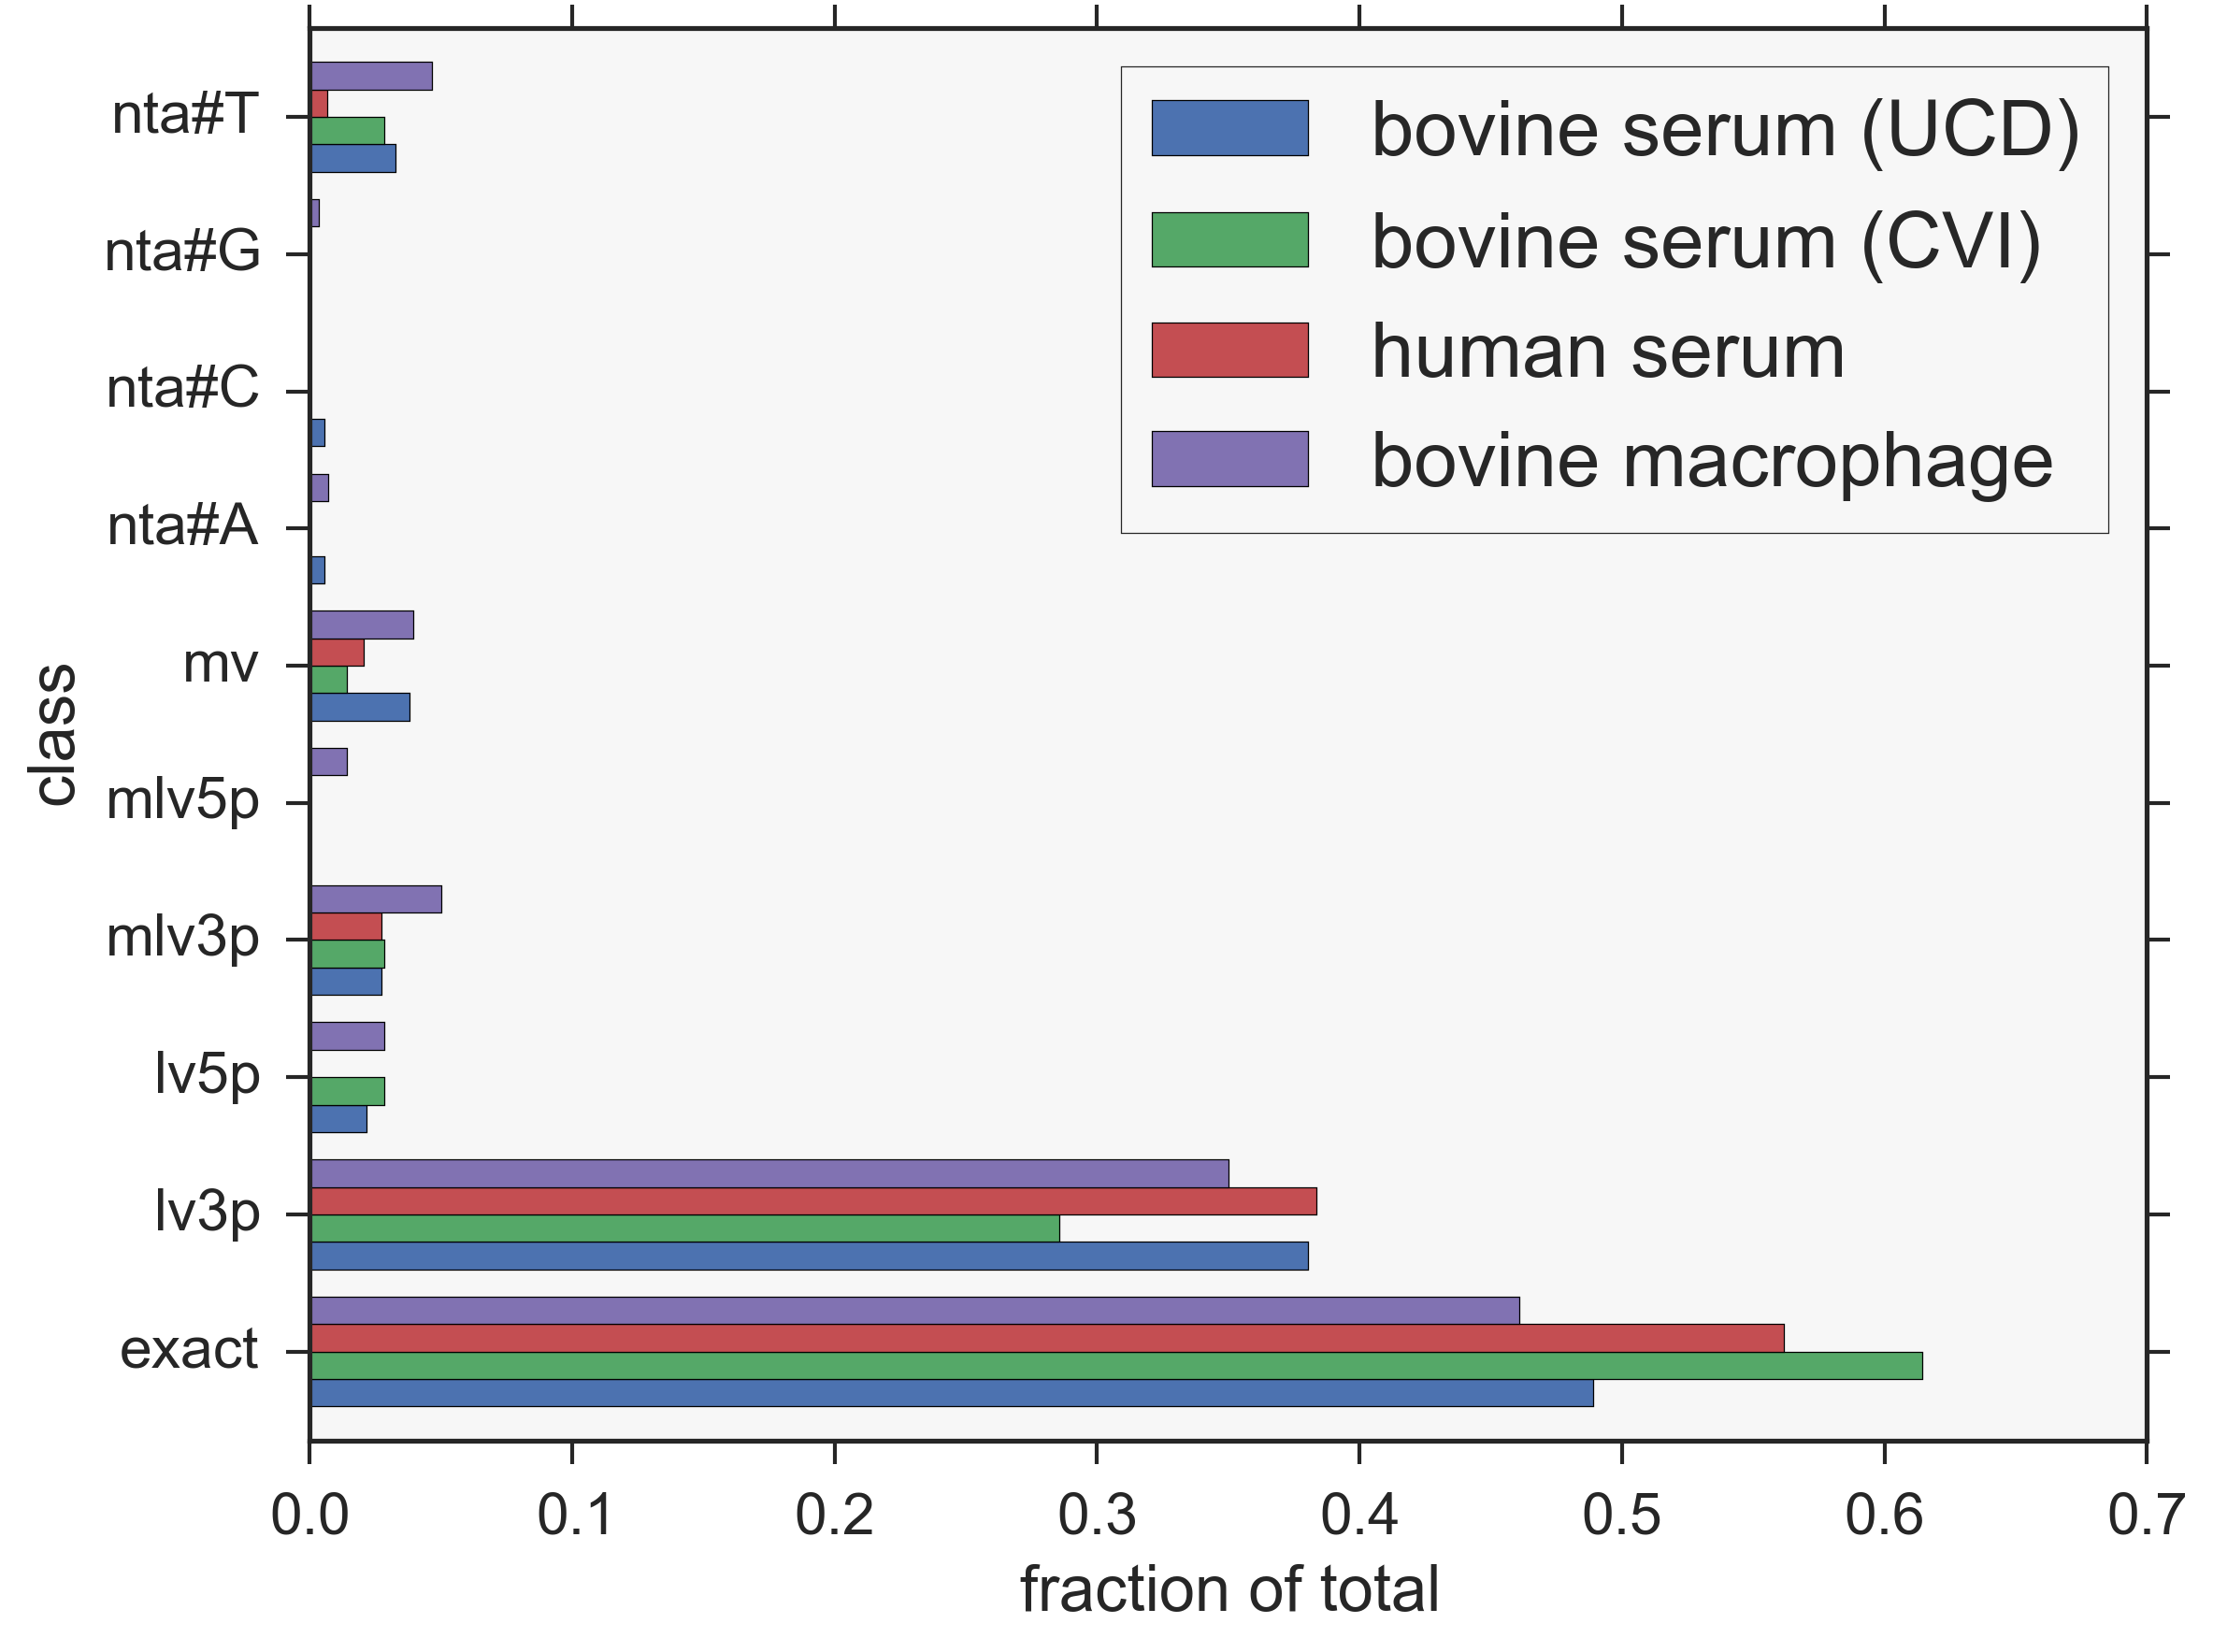

In [7]:
#dominant isomir classes

def countclasses(dom):
    dom['iclass'] = dom.apply(lambda x: x.variant+' '+str(x.pos),1)
    #x=dom.iclass.value_counts()/len(dom) 
    x=dom.variant.value_counts()/len(dom) 
    return x

d1=countclasses(ic)
d2=countclasses(dw)
d3=countclasses(ht)
d4=countclasses(v)
x=pd.concat([d1,d2,d3,d4],1).fillna(0)
x= x.rename(columns={0:'bovine serum (UCD)',1:'bovine serum (CVI)',3:'bovine macrophage',2:'human serum'})
x.plot(kind='barh',width=.8,grid=False,figsize=(8,6))
plt.xlabel('fraction of total')
plt.ylabel('class')
plt.tight_layout()
plt.savefig('isomir_domclasses.png')

cc=0.834924671182
cc=0.456473797097
cc=0.711359989779


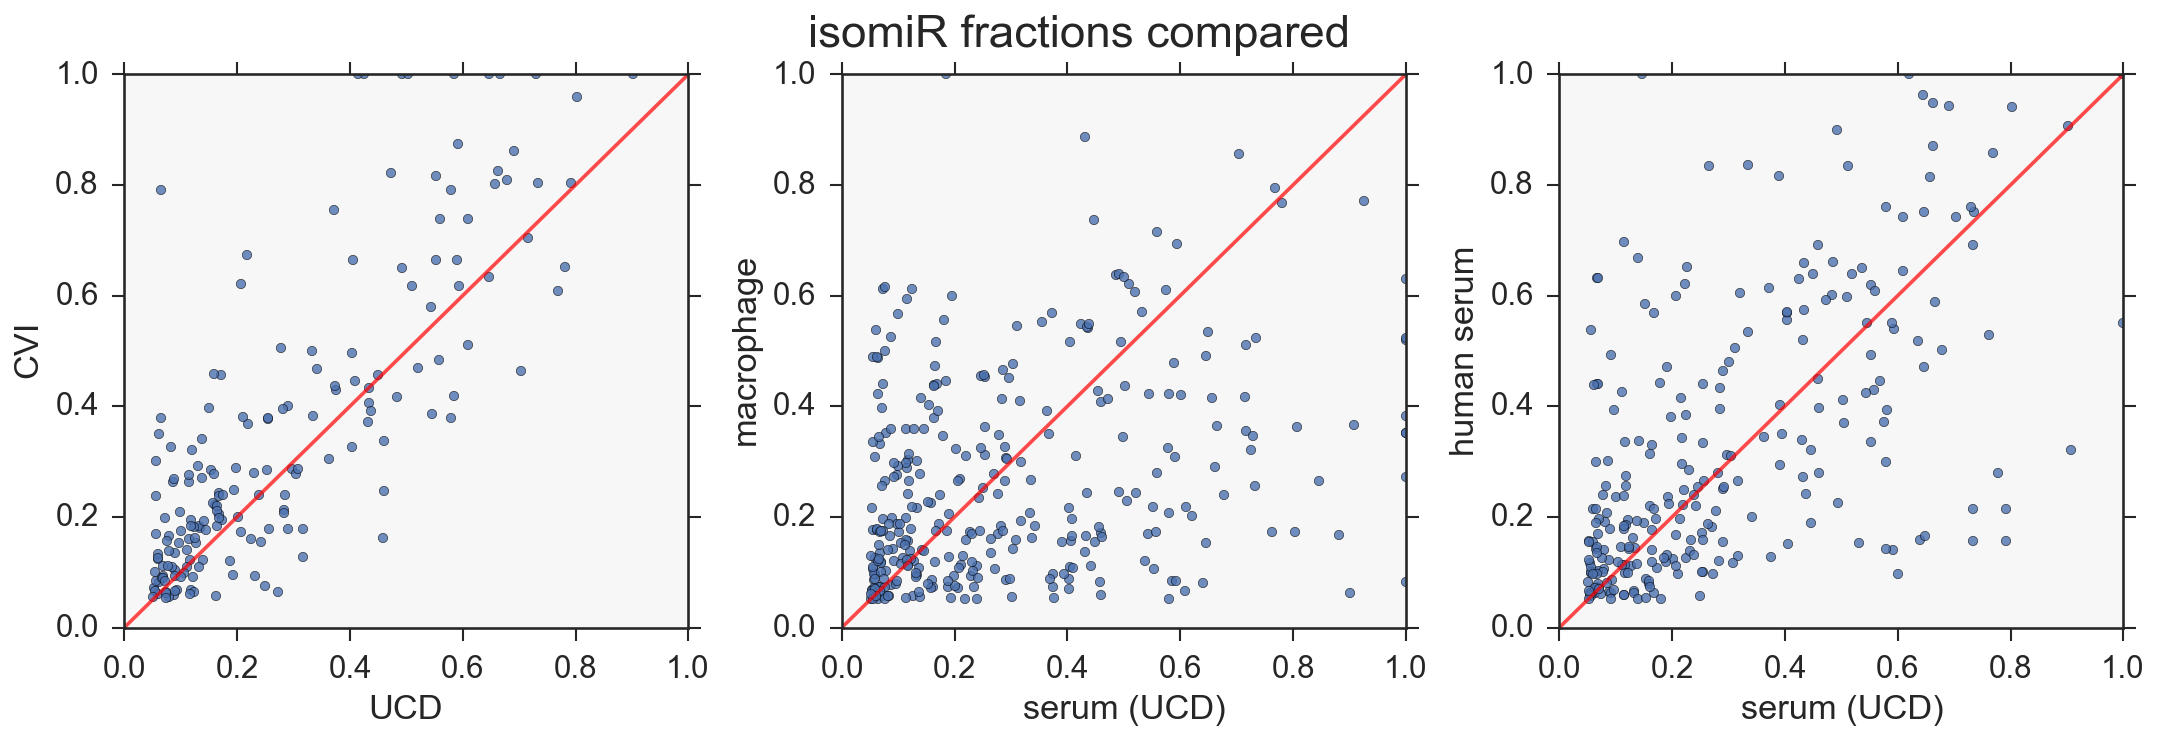

In [8]:
#compare isomirs between data

def diagonal(ax):    
    ax.set_ylim(ax.get_xlim())    
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='red',alpha=0.7)

def compareIsomirs(x,y,a,b,name='',xlabel='',ylabel='',ax=None):
    x=x[x.perc>0.05]
    y=y[y.perc>0.05]
    #fig,ax=plt.subplots(1,2,figsize=(11,6),sharex=False)
    #grid=ax.flat
    '''ax=grid[0]
    d = a.merge(b,on=['read'],how='inner')
    #how much do dominant match?    
    d.plot('isomirs_x','isomirs_y',kind='scatter',logx=True,logy=True,s=40,grid=False,ax=ax)
    #ax.set_xlim((0,1))
    diagonal(ax)'''
    
    b = x.merge(y,on=['read'],how='inner')
    
    #ax=grid[0]
    b.plot('mean_norm_x','mean_norm_y',kind='scatter',logx=True,logy=True,alpha=0.8,grid=False,ax=ax)
    #b.plot('perc_x','perc_y',kind='scatter',alpha=0.8,grid=False,ax=ax)
    ax.set_xlim((1,5e5))
    #ax.set_xlim((0,1))
    diagonal(ax)
    print 'cc=%s' %np.corrcoef(np.log10(b.mean_norm_x),np.log10(b.mean_norm_y))[0][1]

    #ax.set_title(name) #'isomir normalised counts')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

#compareIsomirs(iciso,nkiso,ic,nk,'iconmap nick')
fig,ax=plt.subplots(1,3,figsize=(14.5,5),sharex=False)
grid=ax.flat
compareIsomirs(iciso,dwiso,ic,dw,xlabel='UCD',ylabel='CVI',ax=grid[0])
compareIsomirs(iciso,viso,ic,v,xlabel='serum (UCD)',ylabel='macrophage',ax=grid[1])
compareIsomirs(iciso,htiso,ic,ht,xlabel='serum (UCD)',ylabel='human serum',ax=grid[2])
#grid[0].set_xlabel('mean normalised counts')
#grid[0].set_ylabel('mean normalised counts')
plt.tight_layout()
fig.suptitle('isomiR mean normalised counts compared',fontsize=22)
fig.subplots_adjust(top=0.9)
plt.savefig('isomirs_compared_counts.png') 

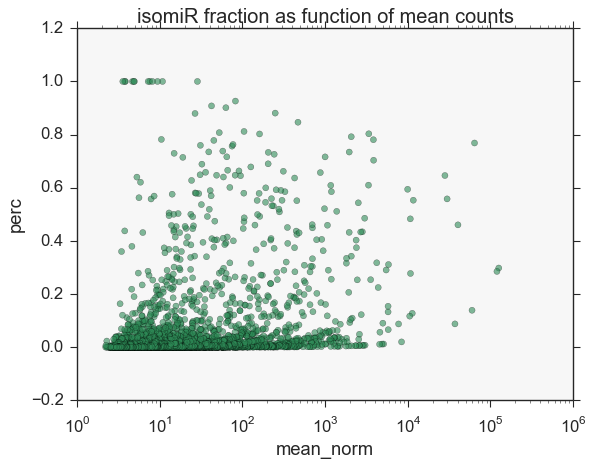

In [6]:
#percentage is not dependant on total NB
x=iciso[iciso.variant=='exact']

iciso.plot('mean_norm','perc',kind='scatter',logx=True,alpha=.6,s=30,c='seagreen',
         grid=False,figsize=(8,6),by='variant')

plt.title('isomiR fraction as function of mean counts')
plt.savefig('isomir_percvscounts.png')

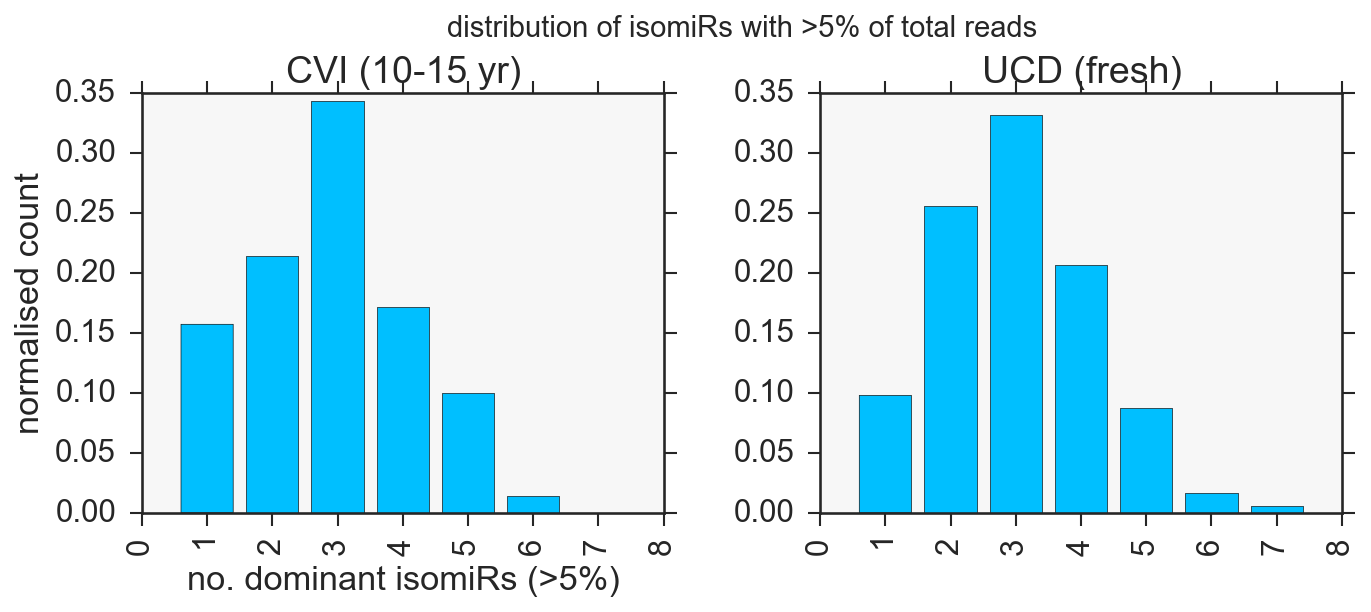

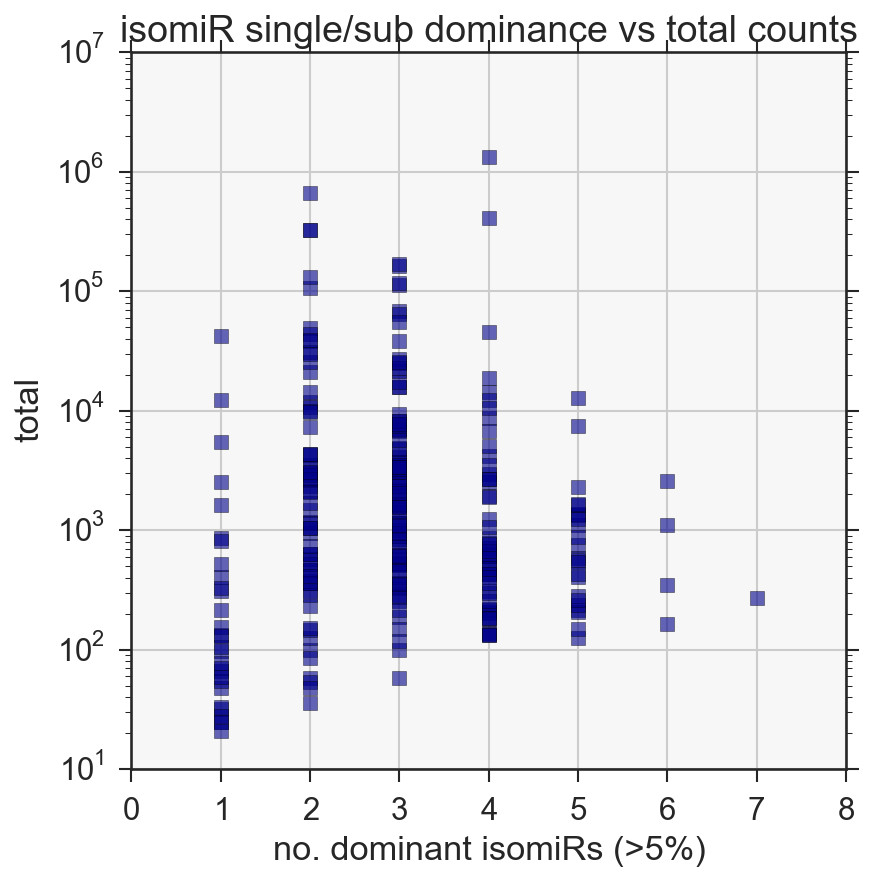

In [16]:
#counts of dominant and sub-dominant dists
def binIsomirs(iso):
    g=iso.groupby('name').agg({'perc':lambda x: (x > .06).sum(), 
                                  'variant': lambda x: base.first(x),'total': lambda x: base.first(x)})    
    return g

cols = ['read','total','perc','length','isoClass']
g1=binIsomirs(dwiso)
g1['tag']='CVI (10-15 yr)'
g2=binIsomirs(iciso)
g2['tag']='UCD (fresh)'
g3=binIsomirs(htiso)
g3['tag']='human'
g4=binIsomirs(viso)
g4['tag']='macrophage'

#print dwiso[dwiso.name=='bta-miR-342'][cols]
subdom = g1.sort('perc',ascending=False)[:6]
onedom = g1.sort('perc')[1:7]
#print subdom
#print onedom
fig,ax=plt.subplots(1,1,figsize=(10,4))
bins=np.arange(0,8)+0.6
g=pd.concat([g1,g2])
h=g.hist('perc',width=0.8,bins=bins,color='deepskyblue',grid=False,ax=ax,by='tag',normed=True)
#sns.kdeplot(g1.perc,kernel='gau',bw=1,ax=h[0])
#sns.kdeplot(g2.perc,kernel='gau',bw=1,ax=h[1])
h[0].set_xlabel('no. dominant isomiRs (>5%)')
h[0].set_ylabel('normalised count')
plt.suptitle('distribution of isomiRs with >5% of total reads',fontsize=14)
plt.subplots_adjust(top=0.85)
plt.savefig('isomir_subdom_breakdown.png')

g.plot('perc','total',kind='scatter',logy=True,s=50,marker='s',alpha=0.6,c='darkblue',figsize=(6,6))
plt.title('isomiR single/sub dominance vs total counts')
plt.xlabel('no. dominant isomiRs (>5%)')
plt.tight_layout() 
plt.savefig('isomir_domperc_counts.png')
#types of variant by no. of sub/dominant isomirs
#print g2.groupby('perc').apply(lambda x: x.variant.value_counts())

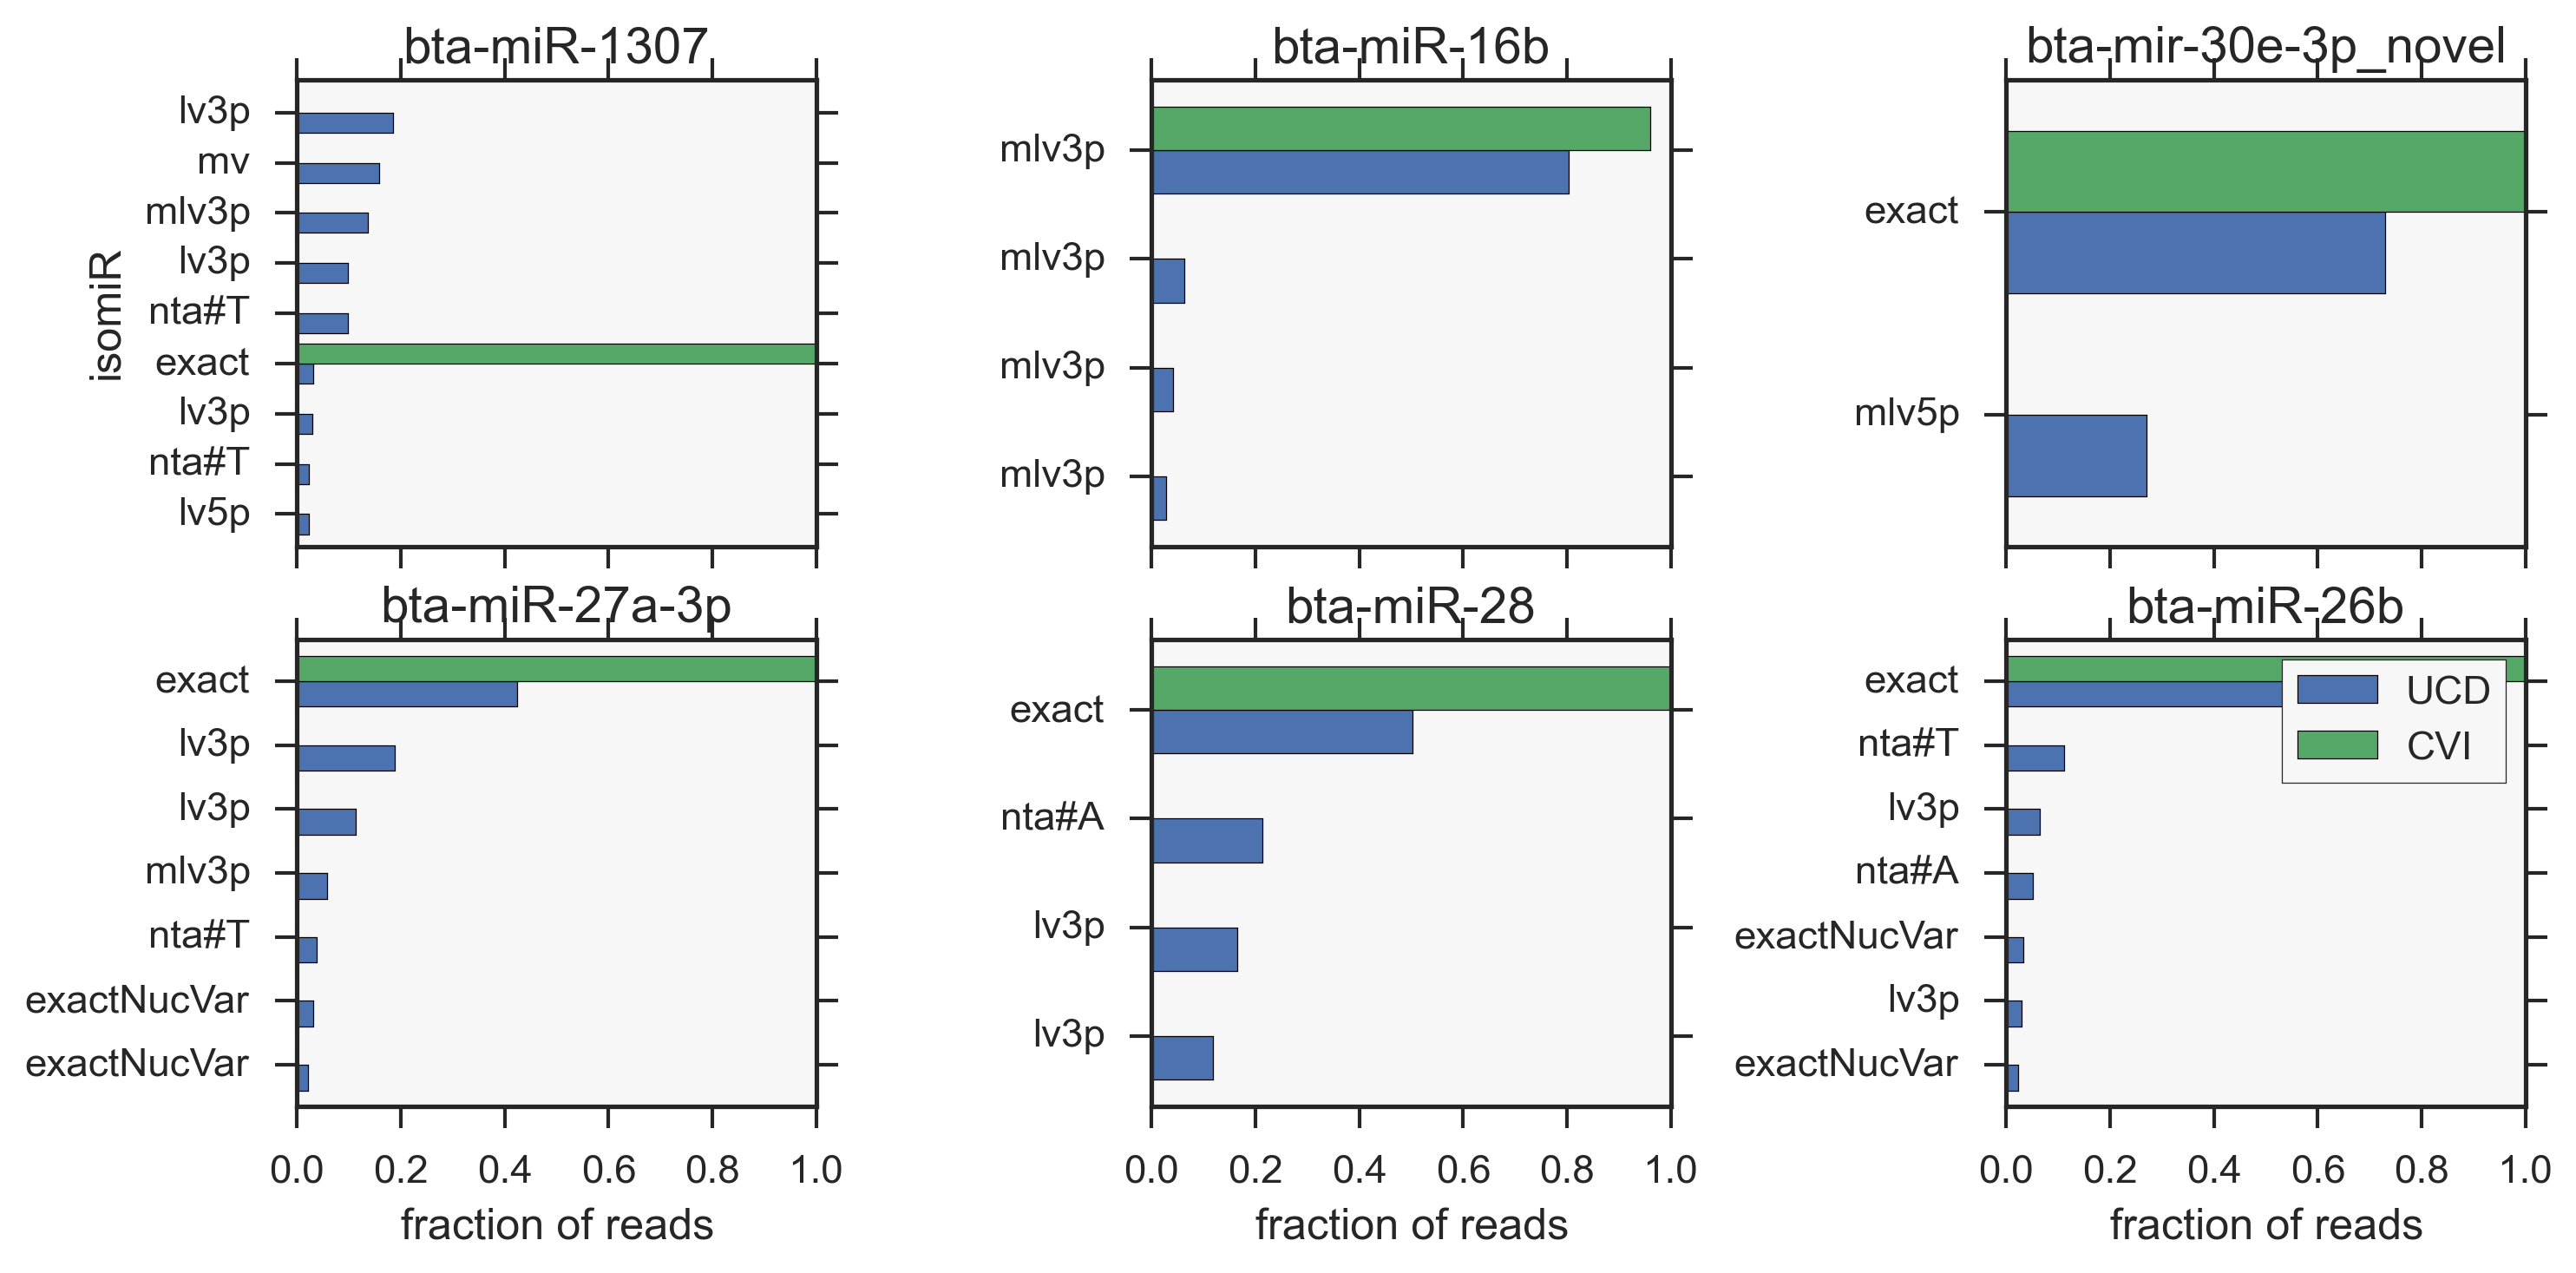

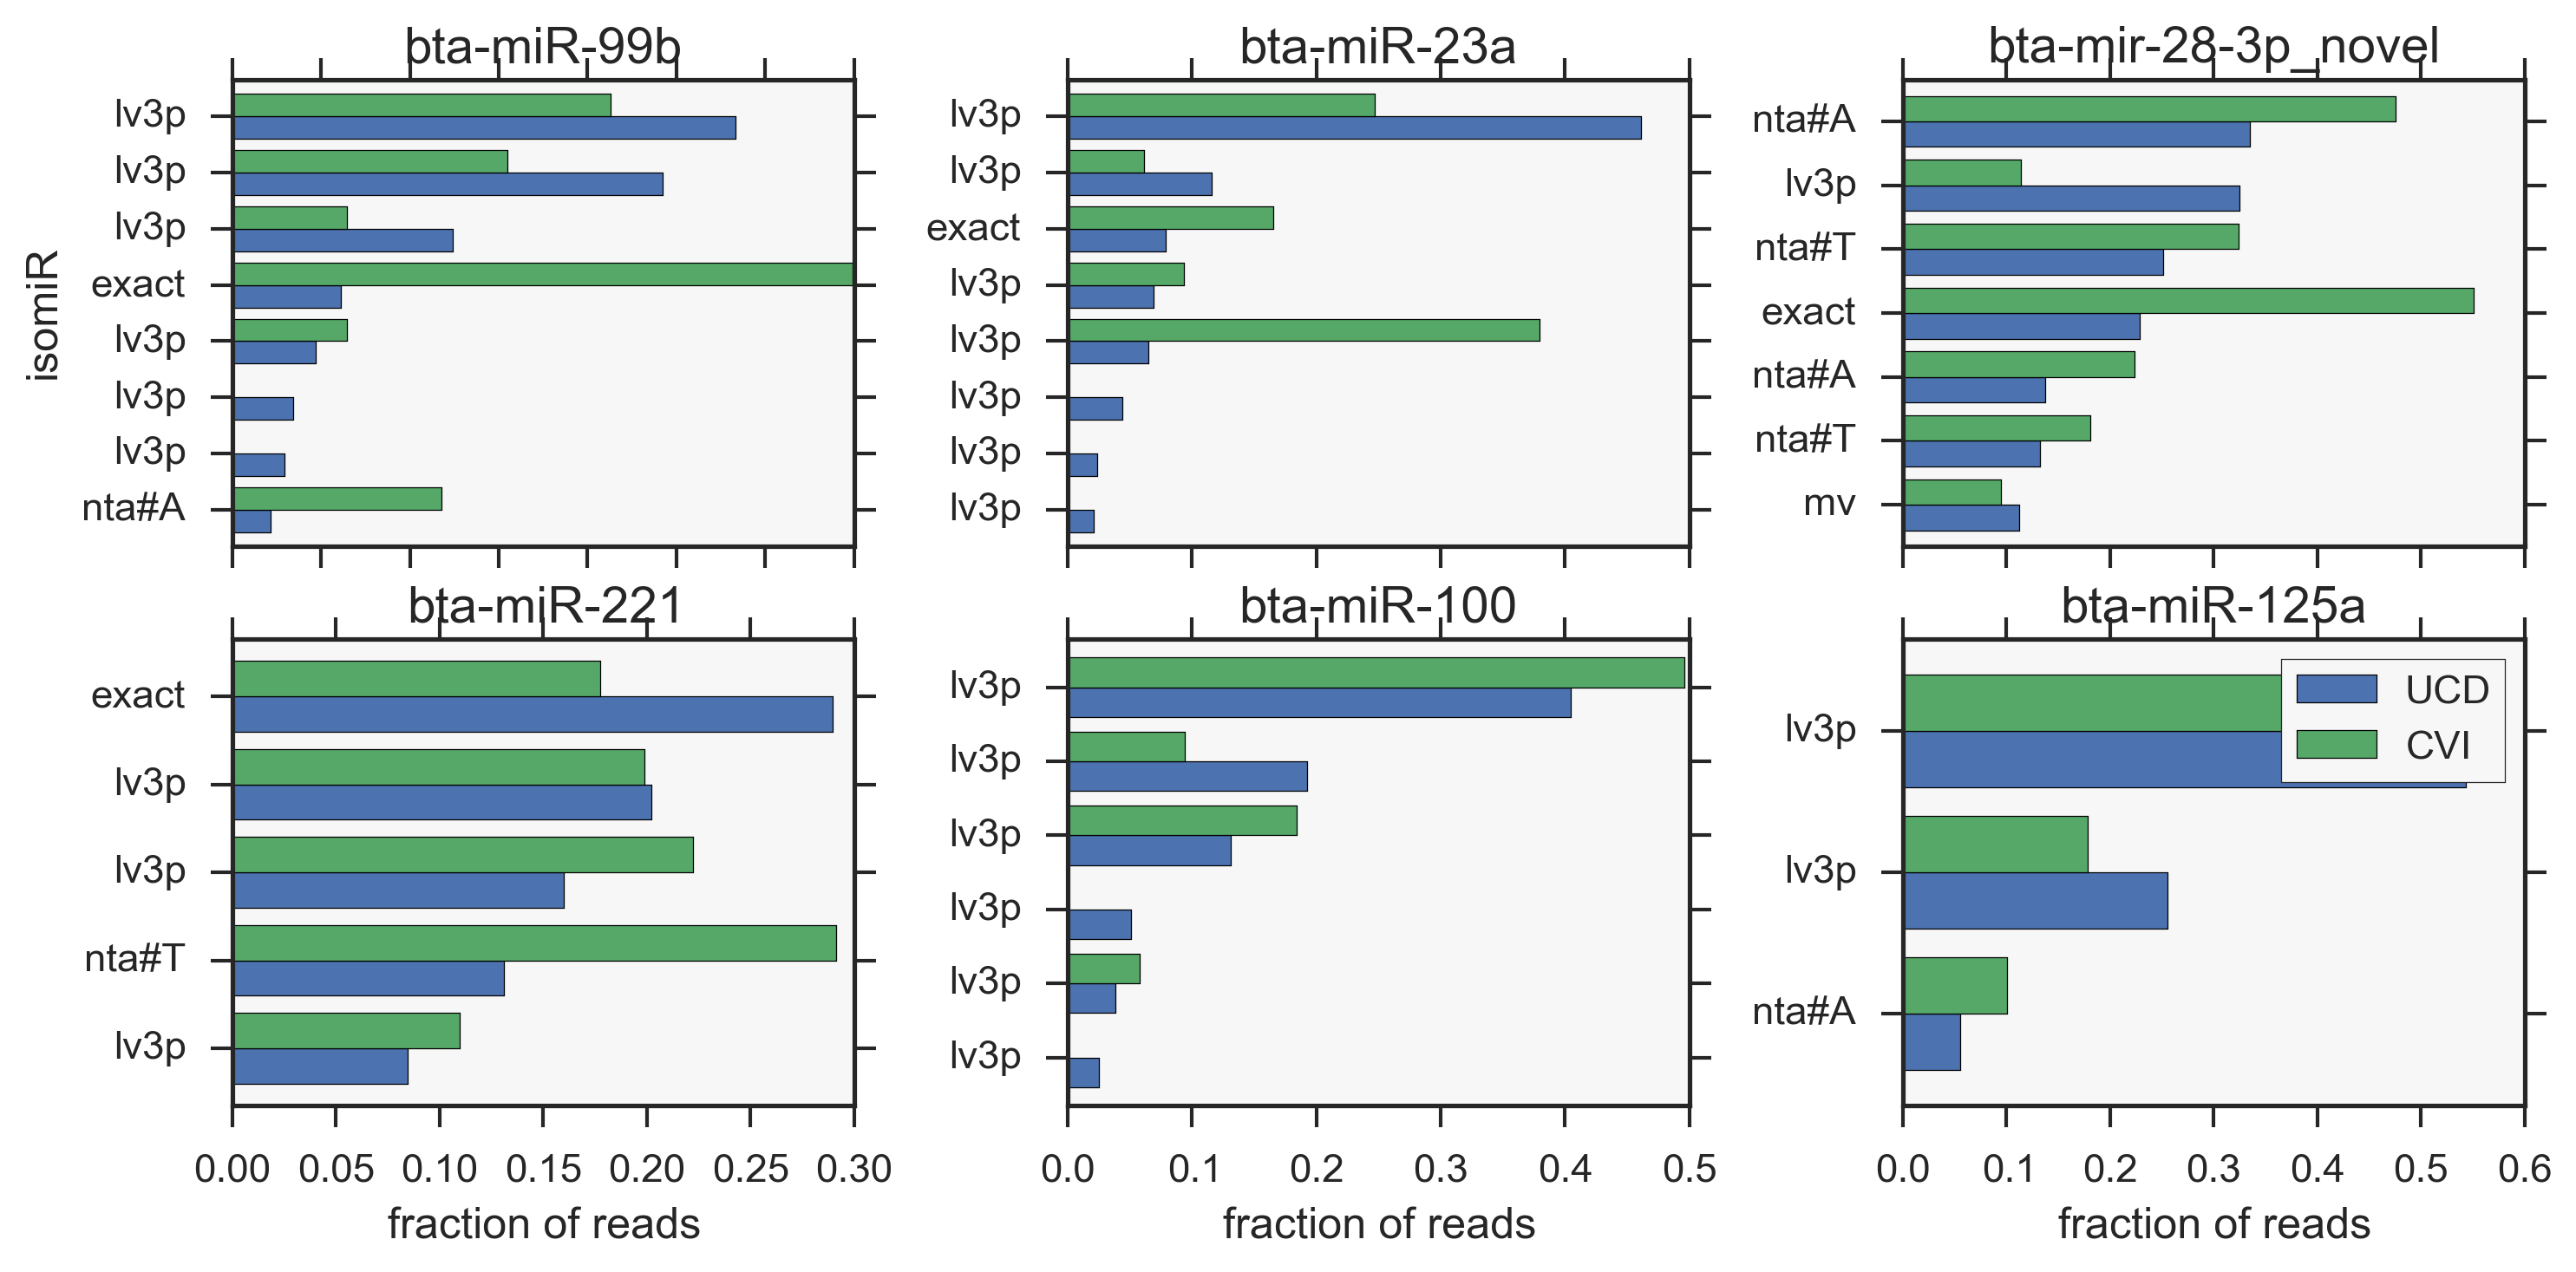

In [22]:
x=iciso; y=dwiso
b = x.merge(y,on=['isoClass','read'],how='left')
#tmp=b[b.name_x=='bta-miR-23a']
#tmp=tmp[tmp.perc_x>0.02]
#print tmp[['isoClass','perc_x','perc_y','mean_norm_x','mean_norm_y','read']]

#names = b.name_x.unique()[:9]
names1 = onedom.index
names2 = subdom.index

def plotisodists(d,names):
    fig,ax=plt.subplots(2,3,figsize=(10,5)) 
    
    grid=ax.flat
    i=0
    for name in names:
        x = d[d.name_x==name]
        if len(x)==0:
            continue
        x=x[x.perc_x>0.02]
        #print name
        #print x[['isoClass_x','perc_x','perc_y']]       
        ax=grid[i]
        x = x.sort('perc_x')
        x.plot(x='variant_x',y=['perc_x','perc_y'],kind='barh',ax=ax,#sharex=False,
               grid=False,legend=False,width=0.8)  
        ax.set_title(name,fontsize=14)
        ax.set_ylabel('')
        ax.set_xlabel('fraction of reads')
        #ax.set_xticklabels('') 
        #ax.set_yticklabels('')
        #ax.set_xlim(0,1) 
        #bars=filter(lambda x: isinstance(x, mpl.patches.Rectangle), ax.get_children())
        #print bars[0]
        i+=1
    grid[0].set_ylabel('isomiR')    
    plt.legend(['UCD','CVI'])    
    plt.tight_layout()
    plt.savefig('isoperc_dists.png')

#mpl.rc('ytick', labelsize=12) 

sns.set_context("notebook", font_scale=1.1)
plotisodists(b,names1)
plotisodists(b,names2)
#other = ['bta-miR-205','bta-miR-92a']
#plotisodists(b,other)

fraction with same dominant isomir: 0.871428571429


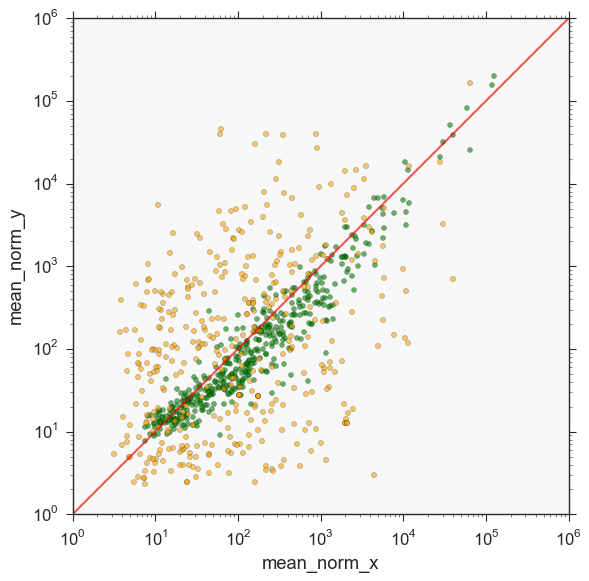

In [209]:
x=iciso; y=nkiso; z=dwiso

def plot(x,y,ax,c):
    b = x.merge(y,on=['read'],how='left')
    b = b[b.perc_x>0.03]
    ax = b.plot('mean_norm_x','mean_norm_y',kind='scatter',logx=True,logy=True,figsize=(8,8),
                s=20,ax=ax,c=c,alpha=0.6,grid=False)
    return ax

ax=plot(iciso,nkiso,None,'green')
#ax=plot(iciso,dwiso,ax,'red')
#ax=plot(iciso,htiso,ax,'skyblue')
ax=plot(iciso,mciso,ax,'orange')
diagonal(ax)

#dominant between datasets?
b = dw.merge(ic,on=['name'],how='left')
print 'fraction with same dominant isomir:', str(len(b[b.variant_x==b.variant_y])/float(len(b)))


184 94
70 27


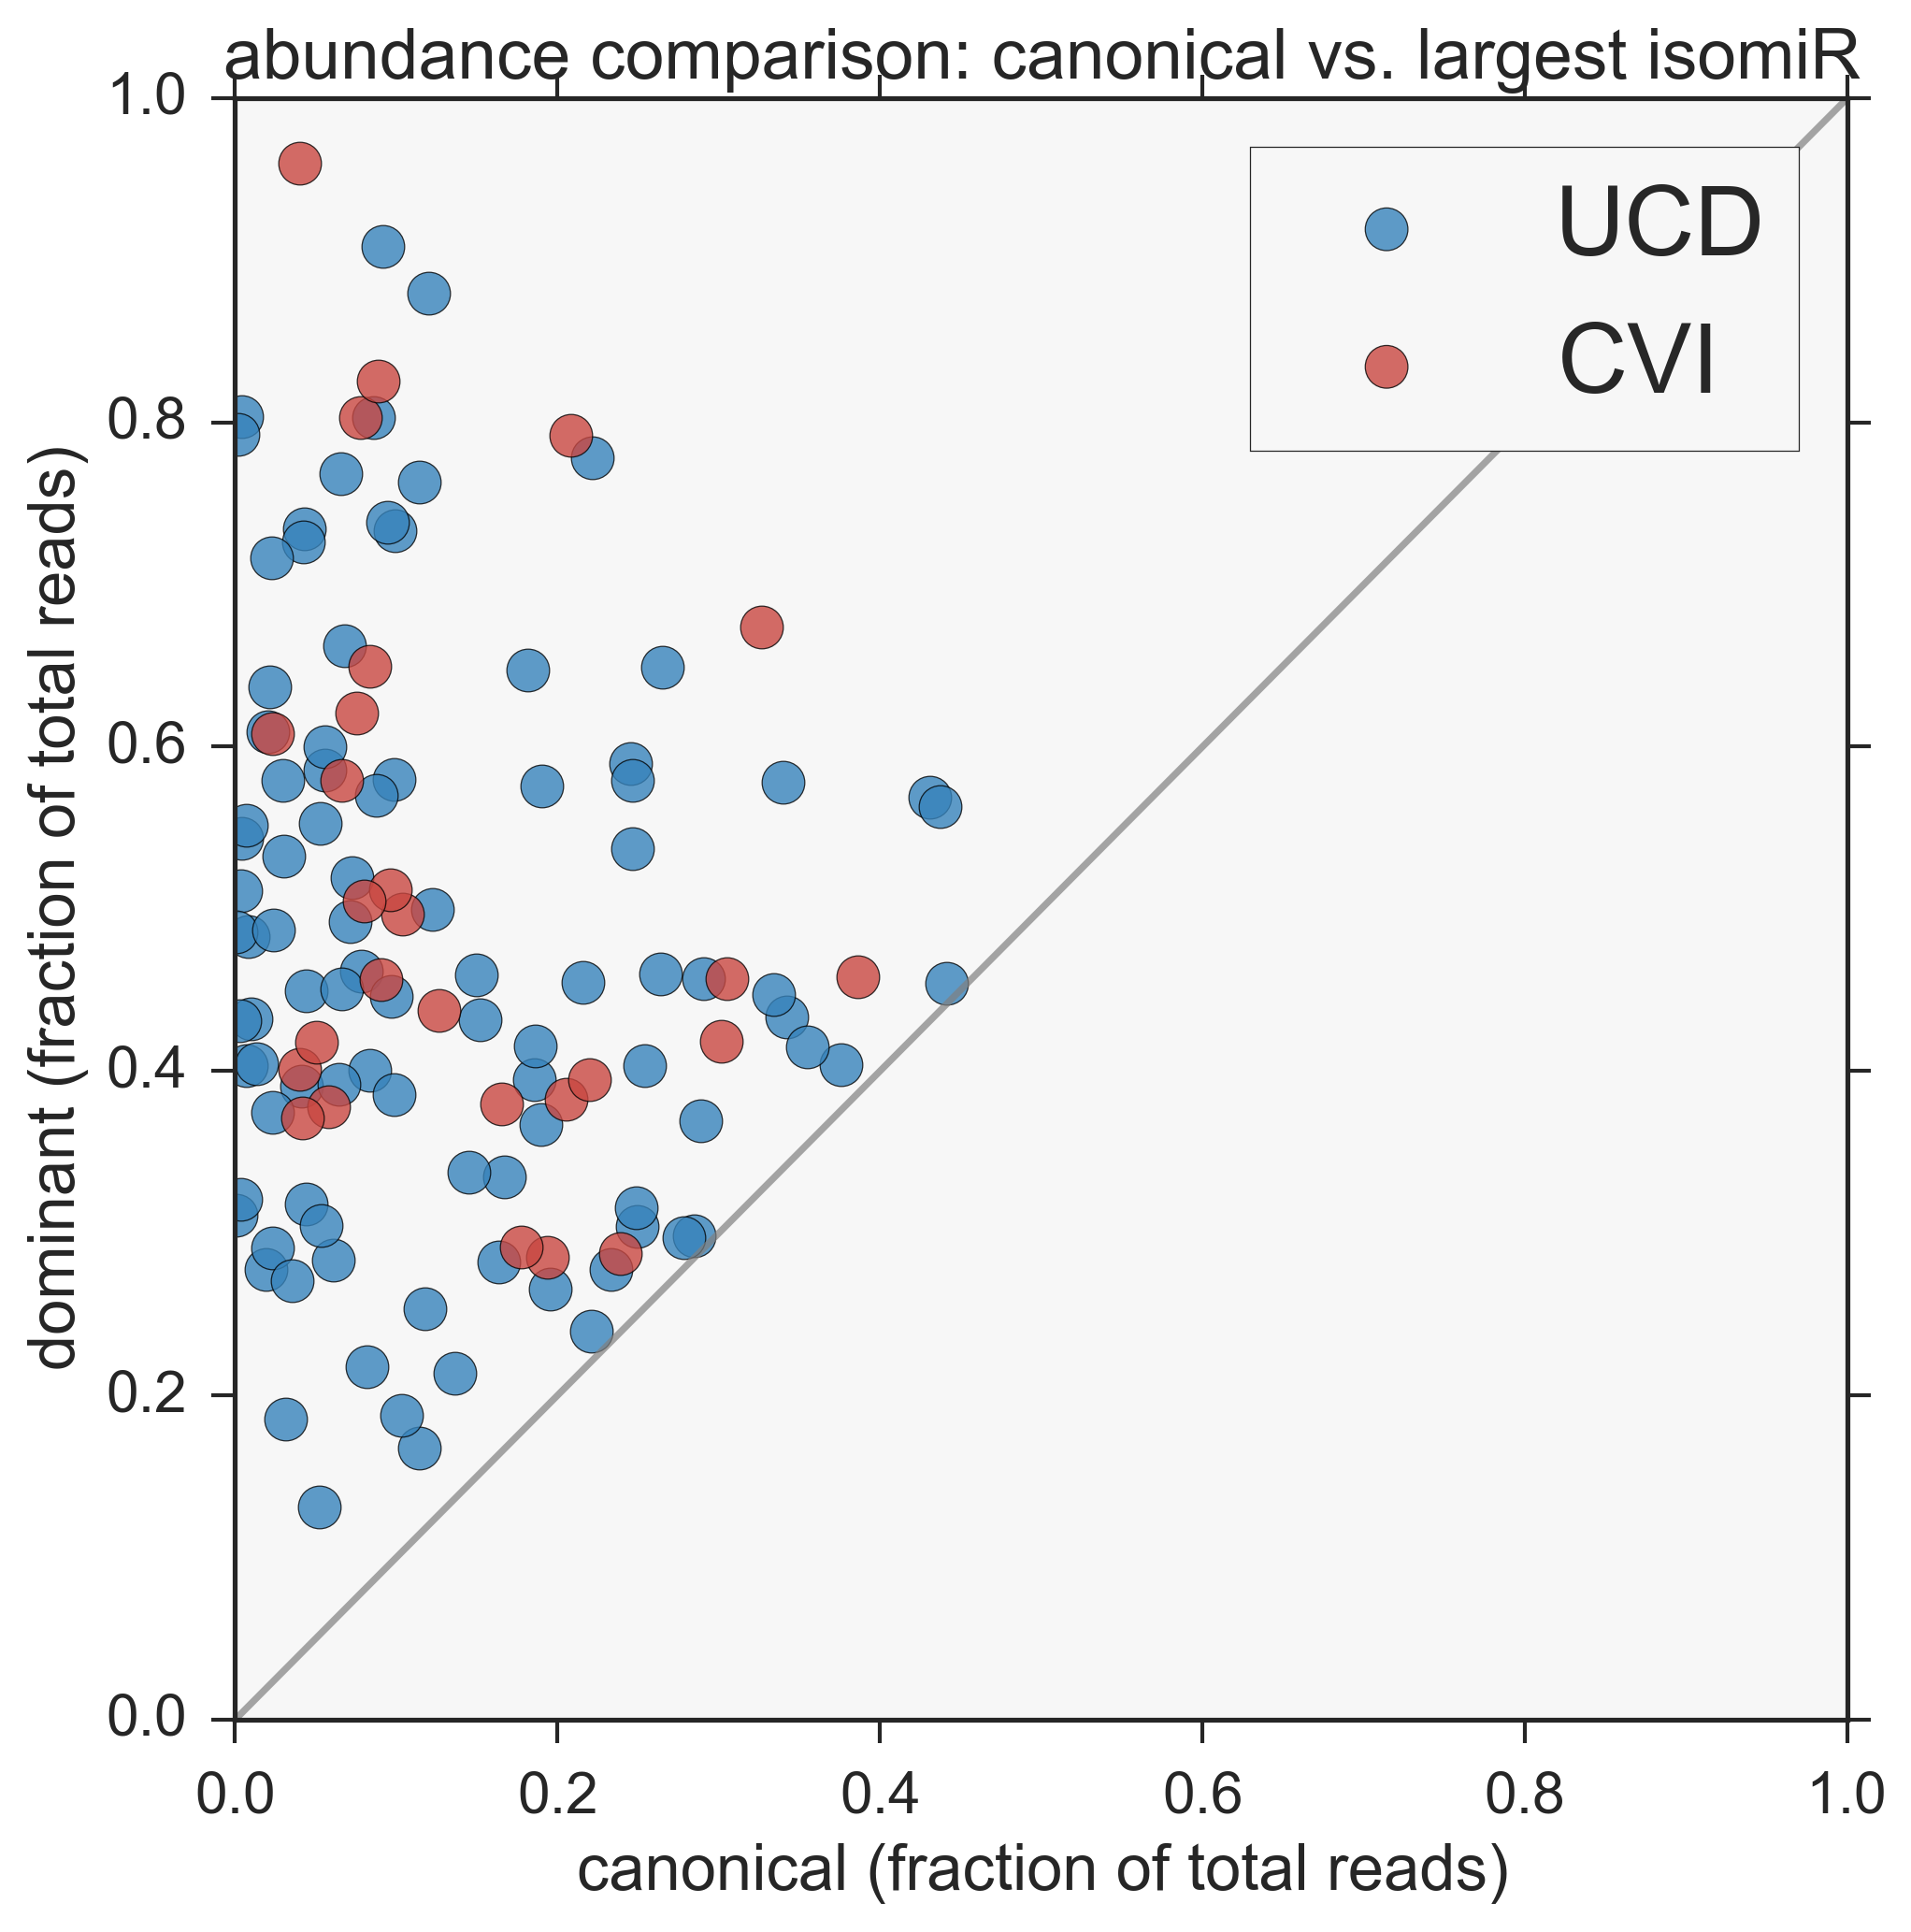

In [29]:
#canonical vs dominant abundance

def compareDominant(x,d,ax,clr='b'):
    cols=['name','read','mean_norm','total','perc']
    canon = x[x.variant=='exact'][cols]
    dom = d[d.variant!='exact']
    print len(d),len(dom)
    x=pd.merge(canon,dom,on='name')
    x['ratio'] = x.perc/x.domisoperc  
    
    clrs = sns.color_palette("RdBu_r", 3)    
    i=0
    l = x.plot(x='perc',y='domisoperc',kind='scatter',s=120,by='pos',subplots=True,ax=ax,c=clr,alpha=0.8,grid=False)
   
    #for p,g in x.groupby('pos'):     
        #print i,p
        #c=clrs[i]
        #c=clr
        #if p<0: c=clrs[0]
        #elif p==0: c=clrs[1]
        #else: c=clrs[2]
        #g.plot(x='perc',y='domisoperc',kind='scatter',s=80,by='pos',subplots=True,ax=ax,c=c)
        #i+=1
        
    #ax.legend(['<1','0','>1'],loc=5)
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))    
    ax.set_xlabel('canonical (fraction of total reads)')
    ax.set_ylabel('dominant (fraction of total reads)')     
    s = x[(x.ratio<=0.3)].sort('domisoperc',ascending=False)
    #print s[['name','read_x','pos','ratio','domisoperc','variant','total_x','total_y']][:20]
    return ax

clrs = sns.color_palette("RdBu_r", 5)
fig,ax=plt.subplots(1,1,figsize=(7,7))     
#grid=axs.flat
compareDominant(iciso,ic,ax,clrs[0])
ax.set_title('abundance comparison: canonical vs. largest isomiR')
compareDominant(dwiso,dw,ax,clrs[-1:])
ax.legend(['UCD','CVI'])
ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='gray',alpha=0.7)   
#grid[1].set_title('old')
#x3=compareDominant(htiso,ht,grid[2])
#grid[2].set_title('human serum')
#x4=compareDominant(viso,v,grid[3])
plt.tight_layout()    
plt.savefig('isomirs_canonical_dom.png')

#xx = pd.merge(x1,x4,on='name')
#xx.plot(x='ratio_x',y='ratio_y',kind='scatter')

In [12]:
#do mismatches with  canonical affect primer 
#which isomir class is relevant??

#check these in miRBase!


In [204]:
#percent of canonical
print len(dw[dw.variant=='exact'])/float(len(dw))
print len(ic[ic.variant=='exact'])/float(len(ic))
print len(nk[nk.variant=='exact'])/float(len(nk))
print len(ht[ht.variant=='exact'])/float(len(ht))

0.614285714286
0.489130434783
0.441176470588
0.561643835616


In [ ]:
#gene cluster isomir patterns? (Guo et al.)

#gene families?

In [28]:
#text for sRNAbench classes figure
data = iciso[iciso.name=='bta-miR-92a'].drop_duplicates('variant')
s = data[['read','variant','isoClass']].sort('variant')
print s
s.to_csv('isoclasses_srnabench.csv')

                         read      variant            isoClass
6      TATTGCACTTGTCCCGGCCTGT        exact               exact
39     TAGTGCACTTGTCCCGGCCTGT  exactNucVar         exactNucVar
22      TATTGCACTTGTCCCGGCCTG         lv3p  lv3p|lv3pT|lv3p#-1
83      ATTGCACTTGTCCCGGCCTGT         lv5p  lv5p|lv5pT|lv5p#-1
400  TATTGCACTTGTCCCGGCCTGTAG        mlv3p       mlv3p|mlv3p#2
284      ATTGCACTTGTCCCGGCCTG           mv                  mv
64     TATTGCACTTGTCCCGGCCTGA        nta#A       nta#A|nta#A#1
309    TATTGCACTTGTCCCGGCCTGC        nta#C       nta#C|nta#C#1
408    TATTGCACTTGTCCCGGCCTGG        nta#G       nta#G|nta#G#1
90   TATTGCACTTGTCCCGGCCTGTAT        nta#T       nta#T|nta#T#1


In [210]:
print iciso[iciso.name=='bta-miR-26b'][['read','variant','isoClass','total']]
print dwiso[dwiso.name=='bta-miR-26b'][['read','variant','isoClass','total']]

                         read      variant            isoClass  total
679    TTCAAGTAATTCAGGATAGGTT        exact               exact    741
2187  TTCAAGTAATTCAGGATAGGTTT        nta#T       nta#T|nta#T#1    124
2985    TTCAAGTAATTCAGGATAGGT         lv3p  lv3p|lv3pT|lv3p#-1     73
3395  TTCAAGTAATTCAGGATAGGTTA        nta#A       nta#A|nta#A#1     58
4326   TTCACGTAATTCAGGATAGGTT  exactNucVar         exactNucVar     37
4558     TTCAAGTAATTCAGGATAGG         lv3p  lv3p|lv3pT|lv3p#-2     33
5165   TGCAAGTAATTCAGGATAGGTT  exactNucVar         exactNucVar     26
5621   TTCAAGTAATTCAGGCTAGGTT  exactNucVar         exactNucVar     21
                       read variant isoClass  total
273  TTCAAGTAATTCAGGATAGGTT   exact    exact    409
